In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
# import plotly.graph_objs as go
# import plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
# import plotly.figure_factory as ff
from keras import backend as K
import pickle

Using TensorFlow backend.
/home/sidathm/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sidathm/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sidathm/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sidathm/.local/lib/python3.6/site-packages/tensorflow/py

In [2]:
InteractiveShell.ast_node_interactivity = 'all'
# from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [3]:
df = pd.read_csv("./convertedJson_phone_review.csv", low_memory=False)
print(df.shape)
# df = df.iloc[:300000, :]
# df = pd.read_csv("./reviews.csv")
print(df.head())

(3447249, 10)
   Unnamed: 0        asin helpful  overall  \
0           0  011040047X  [2, 2]        1   
1           1  0110400550  [0, 0]        5   
2           2  0110400550  [3, 3]        5   
3           3  0110400550  [4, 4]        5   
4           4  0110400550  [0, 1]        1   

                                          reviewText   reviewTime  \
0  The case pictured is a soft violet color, but ...  08 14, 2012   
1  Saw this same case at a theme park store for 2...  11 22, 2012   
2  case fits perfectly and I always gets complime...  07 18, 2013   
3  Best phone case ever . Everywhere I go I get a...  01 13, 2013   
4  It may look cute. This case started off pretty...  11 26, 2012   

       reviewerID      reviewerName          summary  unixReviewTime  
0  A1EWN6KZ4HMLT7       S. Prescott      Wrong color      1344902400  
1   A1YX2RBMS1L9L      Andrea Busch    Great product      1353542400  
2  A180NNPPKWCCU0  Aniya pennington          Perfect      1374105600  
3   A3HVRX

In [4]:
df.overall.value_counts()

5    1708866
4     632300
1     498617
3     351322
2     256144
Name: overall, dtype: int64

In [5]:
from sklearn.utils import shuffle

rating_1 = df[df['overall'] == 1].iloc[:100000, :]
rating_2 = df[df['overall'] == 3].iloc[:100000, :]
rating_3 = df[df['overall'] == 5].iloc[:100000, :]
frames = [rating_1, rating_2, rating_3]
result = pd.concat(frames)
result = shuffle(result)
df = result

In [6]:
df.overall.value_counts()

3    150000
5    100000
1    100000
Name: overall, dtype: int64

In [7]:
combine = [df]
Score_mapping = {1: 1, 3: 2, 5: 3}
for dataset in combine:
    dataset['overall'] = dataset['overall'].map(Score_mapping)
    dataset['overall'] = dataset['overall'].fillna(0)

In [8]:
df.overall.value_counts()

2    150000
3    100000
1    100000
Name: overall, dtype: int64

In [9]:
textColumn = "reviewText"
labelColumn = "overall"

In [10]:
df = df[[textColumn, labelColumn]]
df.dropna()

,reviewText,overall
333654,"The case is ok but, I brought it because it ha...",1
358162,I thought it was gonna charge the whole batter...,1
740088,My sister purchased one and I really liked the...,2
30612,This cable worked very well with my digital ca...,3
190563,"Great value. After a lot of research, one rev...",3
...,...,...
158320,"After a few hours of troubleshooting, I am giv...",1
987949,The extended battery does woek much better tha...,2
1140316,"Unfortunately I think my case, outer silicon c...",2
956540,This case fit very well to your iPhone but is ...,2


In [11]:
df[textColumn]=df[textColumn].astype(str)

In [12]:
print(df.dtypes)
print(df.info())
print(df[labelColumn].value_counts())

reviewText    object
overall        int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 350000 entries, 333654 to 44158
Data columns (total 2 columns):
reviewText    350000 non-null object
overall       350000 non-null int64
dtypes: int64(1), object(1)
memory usage: 8.0+ MB
None
2    150000
3    100000
1    100000
Name: overall, dtype: int64


In [13]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [14]:
def clean_text(text):

        #     """
        #         text: a string
                
        #         return: modified initial string
        #     """
#     text = text.lower() # lowercase text
#     text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
#     text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#     text = text.replace('x', '')
    #    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [15]:

df[textColumn] = df[textColumn].apply(clean_text)

In [16]:
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

In [17]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(df[textColumn].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 122067 unique tokens.


In [18]:
X = tokenizer.texts_to_sequences(df[textColumn].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH,  truncating="post")
print('Shape of data tensor:', X.shape)

Shape of data tensor: (350000, 250)


In [19]:
Y = pd.get_dummies(df[labelColumn]).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (350000, 3)


In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42, shuffle=True)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(315000, 250) (315000, 3)
(35000, 250) (35000, 3)


In [21]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, precision_m, recall_m])
print(model.summary())

W1228 08:32:49.398880 140468942710592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1228 08:32:49.418549 140468942710592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1228 08:32:49.421594 140468942710592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1228 08:32:49.448692 140468942710592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1228 08:32:49.460843 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
epochs = 5
batch_size = 64

In [24]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

W1228 08:32:50.054623 140468942710592 deprecation.py:323] From /home/sidathm/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 283500 samples, validate on 31500 samples
Epoch 1/5
283500/283500 [==============================] - 949s 3ms/step - loss: 0.5843 - acc: 0.7562 - f1_m: 0.7443 - precision_m: 0.7758 - recall_m: 0.7182 - val_loss: 0.5030 - val_acc: 0.7943 - val_f1_m: 0.7894 - val_precision_m: 0.8171 - val_recall_m: 0.7639
Epoch 2/5
283500/283500 [==============================] - 962s 3ms/step - loss: 0.4810 - acc: 0.8046 - f1_m: 0.8021 - precision_m: 0.8201 - recall_m: 0.7852 - val_loss: 0.4822 - val_acc: 0.8028 - val_f1_m: 0.8016 - val_precision_m: 0.8152 - val_recall_m: 0.7886
Epoch 3/5
283500/283500 [==============================] - 963s 3ms/step - loss: 0.4375 - acc: 0.8238 - f1_m: 0.8221 - precision_m: 0.8368 - recall_m: 0.8080 - val_loss: 0.4758 - val_acc: 0.8060 - val_f1_m: 0.8050 - val_precision_m: 0.8187 - val_recall_m: 0.7919
Epoch 4/5
283500/283500 [==============================] - 974s 3ms/step - loss: 0.4026 - acc: 0.8388 - f1_m: 0.8377 - precision_m: 0.8503 - recall_m: 0.8257 - 

In [43]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

In [44]:
print("Accuracy", accuracy)
print("f1_score", f1_score)
print("precision", precision)
print("recall", recall)

Accuracy 0.798457142843519
f1_score 0.7969646788460868
precision 0.8091389675549099
recall 0.7855142857006618


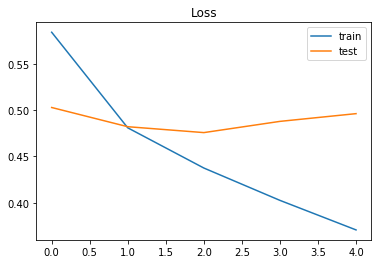

In [45]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

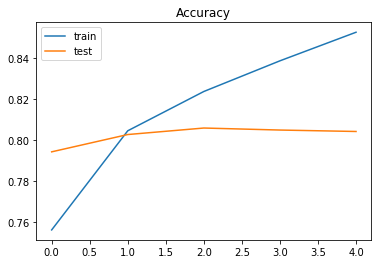

In [46]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

# ROC AUC cureves

In [47]:
y_pred = model.predict(X_test)

In [48]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
%matplotlib inline  

In [49]:
lw = 2
n_classes = 3

In [50]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [51]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [52]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [53]:
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

/home/sidathm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



In [54]:
# Finally average it and compute AUC
mean_tpr /= n_classes

In [55]:
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Some extension of Receiver operating characteristic to multi-class')

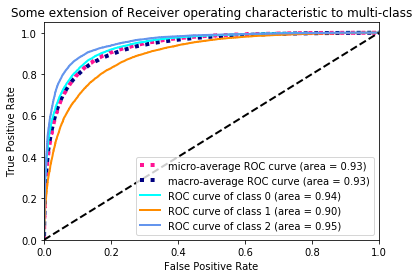

In [56]:
# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

<Figure size 432x288 with 0 Axes>

(0, 0.2)

(0.8, 1)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Some extension of Receiver operating characteristic to multi-class')

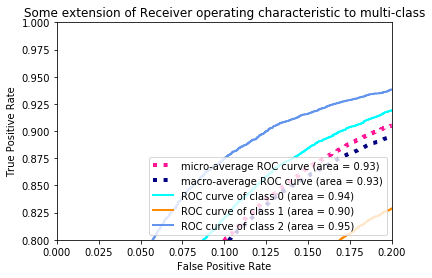

In [57]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix

In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [59]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cnf_matrix = confusion_matrix(Y_test.argmax(1), y_pred.argmax(1), labels=[0, 1, 2])
print(cnf_matrix)

Confusion Matrix
[[ 7975  1667   325]
 [ 1886 11727  1538]
 [  323  1315  8244]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization
[[ 7975  1667   325]
 [ 1886 11727  1538]
 [  323  1315  8244]]


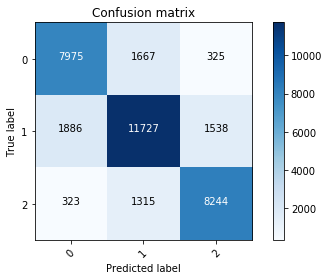

In [60]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2])